In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

import sys
sys.path.append('..')

import modules.stats as st
import modules.plotting as pl
import modules.pandas_funcs as pf

In [2]:
results_dir = os.path.join('..', 'data', 'results')
match_dir = os.path.join('..', 'data', 'matching')


df_k_raw = pd.read_csv(os.path.join(results_dir, 'kinect_gait_metrics.csv'),
                       index_col=0)

df_z_raw = pd.read_csv(os.path.join(results_dir, 'zeno_gait_metrics.csv'),
                       index_col=0)

df_match = pd.read_csv(os.path.join(match_dir, 'match_kinect_zeno.csv'))

# Drop rows where file has no match
df_match = df_match.dropna(axis=0)


df_match_zeno = pd.merge(df_match, df_z_raw, left_on='Zeno', right_index=True)

df_total = pd.merge(df_match_zeno, df_k_raw, left_on='Kinect',
                    right_index=True, suffixes=('_z', '_k'))


# Take columns from total DataFrame to get Kinect and Zeno data
df_k = df_total.filter(like='_k')
df_z = df_total.filter(like='_z')

# Remove suffixes from column names
df_k = df_k.rename(columns=lambda x: str(x)[:-2])
df_z = df_z.rename(columns=lambda x: str(x)[:-2])

# Group by gait metric without suffix
df_k_grouped = df_k.groupby(lambda x: x[:-2], axis=1).mean()
df_z_grouped = df_z.groupby(lambda x: x[:-2], axis=1).mean()

## Visual Results

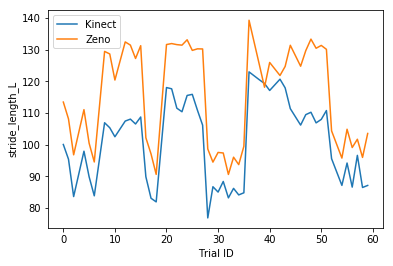

In [3]:
%matplotlib inline

metric = 'stride_length_L'

plt.plot(df_k[metric])
plt.plot(df_z[metric])

plt.xlabel('Trial ID')
plt.ylabel(metric)

plt.legend(['Kinect', 'Zeno'])
plt.show()

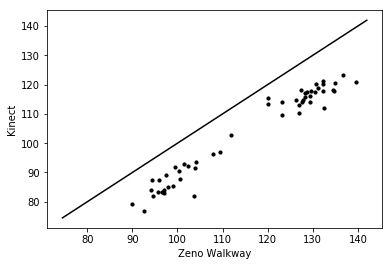

In [4]:
x_label, y_label = 'Zeno Walkway', 'Kinect'
metric = 'stride_length_R'
    
pl.compare_measurements(df_z[metric], df_k[metric], c='k', s=10)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

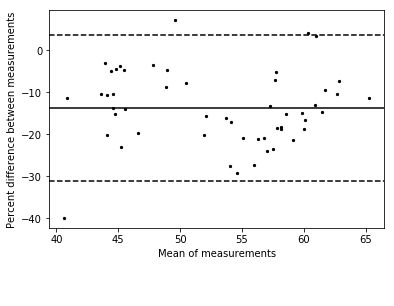

In [5]:
metric = 'step_length_L'

# Bland-Altman object
bland_obj = st.BlandAltman(df_k[metric], df_z[metric], percent=True)

pl.plot_bland_altman(bland_obj.means, bland_obj.differences, bland_obj.bias, 
                     bland_obj.limits_of_agreement, percent=True)

## Quantitative Results

In [6]:
funcs = {'Pearson': lambda a, b: pearsonr(a, b)[0],
        'Spearman': lambda a, b: spearmanr(a, b)[0],
        'Abs rel error': lambda a, b: st.relative_error(a, b, absolute=True).mean(),
        'Bias': lambda a, b: st.BlandAltman(a, b).bias, 
        'Range': lambda a, b: st.BlandAltman(a, b).range}
 
    
d = {name: pf.apply_to_columns(df_k, df_z, func) for name, func in funcs.items()}

df_results = pd.DataFrame(d).T
df_results

,step_length_L,step_length_R,stride_length_L,stride_length_R,stride_time_L,stride_time_R,stride_velocity_L,stride_velocity_R,stride_width_L,stride_width_R
Pearson,0.799495,0.954685,0.916826,0.978624,0.934586,0.923024,0.924197,0.964994,0.733869,0.826439
Spearman,0.795526,0.902928,0.834970,0.940983,0.683337,0.697628,0.784854,0.871169,0.720482,0.754034
Abs rel error,0.132174,0.139881,0.124506,0.106992,0.184344,0.178735,0.108338,0.101541,4.643986,4.976174
Bias,-0.138650,-0.151594,-0.133601,-0.113529,-0.206487,-0.199905,0.068964,0.079656,0.827035,0.768098
Range,0.348030,0.202369,0.204724,0.128237,0.345384,0.355510,0.403454,0.316187,4.419880,3.324837


In [7]:
d = {name: pf.apply_to_columns(df_k_grouped, df_z_grouped, func) for name, func in funcs.items()}

df_grouped = pd.DataFrame(d).T
df_grouped

,step_length,stride_length,stride_time,stride_velocity,stride_width
Pearson,0.958247,0.971388,0.934360,0.950525,0.810824
Spearman,0.892342,0.879450,0.674835,0.818834,0.775975
Abs rel error,0.133782,0.115626,0.181620,0.101894,2.560561
Bias,-0.144071,-0.123197,-0.203033,0.074736,0.793346
Range,0.153037,0.124997,0.336999,0.338732,3.799844


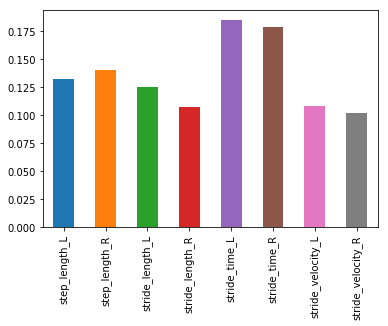

In [8]:
df_results.loc['Abs rel error'][:-2].plot.bar()

In [9]:
df_sides = df_results.groupby(lambda x: x.split('_')[-1], axis=1).mean()
df_sides

,L,R
Pearson,0.861795,0.929553
Spearman,0.763834,0.833349
Abs rel error,1.038669,1.100664
Bias,0.083452,0.076545
Range,1.144294,0.865428


In [10]:
df_grouped.stride_length * 100

Pearson          97.138813
Spearman         87.945018
Abs rel error    11.562621
Bias            -12.319721
Range            12.499750
Name: stride_length, dtype: float64

In [11]:
df_rel_error = abs(df_k - df_z) / df_z * 100

In [13]:
max_idx = df_rel_error.stride_length_L.idxmax()

In [18]:
df_k.loc[max_idx]

step_length_L        32.538961
step_length_R        42.892671
stride_length_L      76.875589
stride_length_R      85.319585
stride_time_L         1.200000
stride_time_R         1.133333
stride_velocity_L    64.492537
stride_velocity_R    75.281987
stride_width_L        7.983275
stride_width_R       13.609342
Name: 28, dtype: float64

In [19]:
df_z.loc[max_idx]

step_length_L        48.764
step_length_R        51.050
stride_length_L      98.647
stride_length_R      99.098
stride_time_L         1.475
stride_time_R         1.505
stride_velocity_L    67.275
stride_velocity_R    66.694
stride_width_L        8.195
stride_width_R        8.623
Name: 28, dtype: float64

In [20]:
df_match.loc[max_idx]

Zeno      B_2014-12-16_P007_Post_tc_A
Kinect       2014-12-16_P007_Post_007
Name: 28, dtype: object